### This notebook generates the CAPE-omega relationships for MCSs in the idealized RCE simulations. First import libraries and constants.

In [1]:
import numpy as np
from scipy import stats
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib import cm
import random

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# blue-to-red colormap
BR_color_cycle = ["navy", "blue", "lightskyblue", "tomato", "red", "darkred"]

In [2]:
# parameter values for this script
ssts = np.arange( 290, 315, 5 )
pc2 = 99
nbin = 40
font_size = 20
sz = 80
threshold = 25

### Loading RCE data and identifying the 550 hPa level

In [79]:
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/all-var-percentile/'
mean_RCE, p99_RCE, rad = read_RCE_files( path )

# Verifying that 17 is the index closest to 550 hPa
for i in np.arange(10):
    n = random.randint( 0, mean_RCE[0]['ascent'].shape[1] )
    print( mean_RCE[0]['p'][n,17].values )
    
print( mean_RCE[0]['ascent'].shape )
print( np.nanmax(mean_RCE[0]['ascent'][:,17]), np.nanmean(mean_RCE[0]['ascent'][:,17]), np.nanmin(mean_RCE[0]['ascent'][:,17]) )

538.855
539.1309
539.403
538.96796
539.0249
539.02924
539.18896
539.3419
538.855
539.1309
(526, 64)
18.12682 8.691558 4.135805


In [78]:
cape_bins_list = [ [] for i in mean_RCE ]
ascent_list = [ [] for i in mean_RCE ]
ascent_99_list = [ [] for i in mean_RCE ]
ascent_error_list = [ [] for i in mean_RCE ]
for iterator, array in enumerate( p99_RCE ):
    cape_RCE = array['CAPE'].to_numpy()
    ascent_RCE = array['omega'][:,17].to_numpy()  # pressure velocities at 550 hPa, multiply by -1 as negative = ascent
    ascent_RCE = xr.where( ascent_RCE < 0, -1.*ascent_RCE, np.nan ) # we only want ascent rates
    print(len(ascent_RCE))

    cape_bins, ascent_vals, _, ascent_99_vals, _, ascent_error, _, _ = \
        bin_stat_function( nbin, np.nanmin(cape_RCE), np.nanpercentile(cape_RCE,99), cape_RCE, ascent_RCE, pc2=pc2, threshold=threshold ) #20000 as upper bound for max_RCE
    
    cape_bins_list[iterator] = cape_bins
    ascent_list[iterator] = ascent_vals
    ascent_99_list[iterator] = ascent_99_vals
    ascent_error_list[iterator] = ascent_error

526
590
896
930
692


### Filter the scaling of CAPE and omega for different MCS extents

In [75]:
cape_RCE = RCE_concat( mean_RCE, 'CAPE' )
omega_RCE = -1.*RCE_concat( mean_RCE, 'omega' )
omega_RCE = xr.where( omega_RCE[:,17] > 0, omega_RCE[:,17], np.nan ) # we only want ascent rates
rad_RCE = np.concatenate( [r for r in rad], axis=0 )
unit = np.sqrt( np.nanpercentile(cape_RCE,99) )/4.

loo = np.percentile( rad_RCE, 25 )
upp = np.percentile( rad_RCE, 75 )
cape_bins_all, ascent_vals_all, _, ascent99_vals_all, _, _, _, _ = \
        bin_stat_function( nbin, np.nanmin(cape_RCE), np.nanpercentile(cape_RCE,99), cape_RCE, omega_RCE, pc2=pc2, threshold=threshold )
cape_bins_small, ascent_vals_small, _, ascent99_vals_small, _, _, _, _ = \
        bin_stat_function( nbin, np.nanmin(cape_RCE[rad_RCE<=loo]), np.nanpercentile(cape_RCE,99), cape_RCE[rad_RCE<=loo],
                          omega_RCE[rad_RCE<=loo], pc2=pc2, threshold=10 )
cape_bins_large, ascent_vals_large, _, ascent99_vals_large, _, _, _, _ = \
        bin_stat_function( nbin, np.nanmin(cape_RCE[rad_RCE>=upp]), np.nanpercentile(cape_RCE,99), cape_RCE[rad_RCE>=upp],
                           omega_RCE[rad_RCE>=upp], pc2=pc2, threshold=10 )

### Plot the ascent rate versus CAPE

In [76]:
def squared(x):
    return x**2

def sqrt(x):
    return np.sqrt(x)

ValueError: Inputs must not be empty.

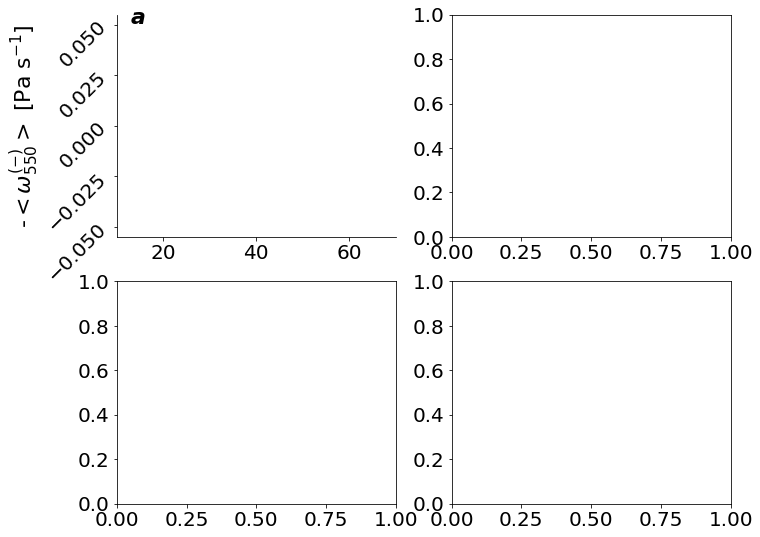

In [77]:
fig, ax = plt.subplots( 2, 2, figsize =(11, 9) )

ylab = [ r'-$<\omega_{550}^{(-)}>$ [Pa s$^{-1}$]', r'-$\omega_{550,99}^{(-)}$ [Pa s$^{-1}$]',
         r'-$<\omega_{550}^{(-)}>$ [Pa s$^{-1}$]', r'-$\omega_{550,99}^{(-)}$ [Pa s$^{-1}$]' ]
labels = [ '', '' , r'(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]', '(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]' ]
let = [ 'a', 'b', 'c', 'd' ]
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
cape_array = np.linspace( 15, 65, 50 )

for i, axis in enumerate(ax.flatten()): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [10, 70] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    
    axis.text( 0.05, 0.96, let[i], weight='bold', style='italic', fontsize=font_size+2, transform=axis.transAxes )
    if i == 0:
        for j, k, l, m in zip(cape_bins_list, ascent_list, np.arange(len(cape_bins_list)), ascent_error_list):
            axis.scatter( np.sqrt(j), k, color = BR_color_cycle[l], s=sz, edgecolor='black', label=str(ssts[l])+' K'  )
            axis.errorbar( np.sqrt(j), k, xerr=None, yerr=m/2, color = BR_color_cycle[l], ls='none', zorder=-1, alpha=0.75 )
            out, y_predicted, x_input, _ = linindx( np.sqrt(j), k )
            print(out.slope)
            axis.plot( x_input, y_predicted, color=BR_color_cycle[l], linewidth=2, zorder=10 )
        #axis.legend( loc='upper left', ncol=2, frameon=False, fontsize=16, columnspacing=0.4, handletextpad=0.05 )
        axis.set_ylim( [0,2.5] )
        
    elif i == 1:
        for j, k, l in zip(cape_bins_list, ascent_99_list, np.arange(len(cape_bins_list))):
            axis.scatter( np.sqrt(j), k, color = BR_color_cycle[l], s=sz, edgecolor='black', label=str(ssts[l])+' K' )
            out, y_predicted, x_input, _ = linindx( np.sqrt(j), k )
            axis.plot( x_input, y_predicted, color=BR_color_cycle[l], linewidth=2, zorder=10 )
        axis.legend( ncol=2, loc='upper left', frameon=False, fontsize=16, columnspacing=0.4, bbox_to_anchor=(0.5,0.5),
                    handletextpad=0.05 )
        axis.set_ylim( [0,5.5] )
        
    elif i == 2:
        axis.scatter( np.sqrt(cape_bins_all), ascent_vals_all, s=sz, color='darkblue', edgecolor='k' )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_all), ascent_vals_all )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=2, zorder=10 )
        axis.text( 0.05, 0.7, r"$m$ = " + f"{out.slope:.3f}" + r" Pa s$^{-1}$ / " + "\n" + "(J kg$^{-1}$)", color='darkblue',
                  fontsize=font_size-2, transform=axis.transAxes )
        
        axis.scatter( np.sqrt(cape_bins_small), ascent_vals_small, s=sz, color='gold', edgecolor='k' )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_small), ascent_vals_small )
        axis.plot( x_input, y_predicted, color='gold', linewidth=2, zorder=10 )
        axis.text( 0.05, 0.6, r"$m$ = " + f"{out.slope:.3f}", color='gold',
                  fontsize=font_size-2, transform=axis.transAxes )
        
        axis.scatter( np.sqrt(cape_bins_large), ascent_vals_large, s=sz, color='darkorange', edgecolor='k' )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_large), ascent_vals_large )
        axis.plot( x_input, y_predicted, color='darkorange', linewidth=2, zorder=10 )
        axis.text( 0.05, 0.1, r"$m$ = " + f"{out.slope:.3f}", color='darkorange',
                  fontsize=font_size-2, transform=axis.transAxes )
        
        ax2 = axis.secondary_xaxis( -0.4, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 400, 1600, 3600] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )
        axis.set_ylim( [0,2.5] )
        
    else:
        axis.scatter( np.sqrt(cape_bins_all), ascent99_vals_all, s=sz, color='darkblue', edgecolor='k' )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_all), ascent99_vals_all )
        print(out)
        axis.plot( cape_array, out.slope*cape_array + out.intercept, color='darkblue', linewidth=2, zorder=10 )
        axis.text( 0.05, 0.7, r"$m$ = " + f"{out.slope:.2f}" + r" Pa s$^{-1}$ / " + "\n" + "(J kg$^{-1}$)", color='darkblue',
                  fontsize=font_size-2, transform=axis.transAxes )
        #print(out.slope, out.rvalue, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_small), ascent99_vals_small, s=sz, color='gold', edgecolor='k' )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_small), ascent99_vals_small )
        axis.plot( x_input, y_predicted, color='gold', linewidth=2, zorder=10 )
        axis.text( 0.05, 0.2, r"$m$ = " + f"{out.slope:.2f}", color='gold',
                  fontsize=font_size-2, transform=axis.transAxes )
        #print(out.slope, out.rvalue, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_large), ascent99_vals_large, s=sz, color='darkorange', edgecolor='k' )
        out, y_predicted, x_input, _ = linindx( np.sqrt(cape_bins_large), ascent99_vals_large )
        axis.plot( x_input, y_predicted, color='darkorange', linewidth=2, zorder=10 )
        axis.text( 0.05, 0.1, r"$m$ = " + f"{out.slope:.2f}", color='darkorange',
                  fontsize=font_size-2, transform=axis.transAxes )
        #print(out.slope, out.rvalue, out.pvalue)
                
        ax2 = axis.secondary_xaxis( -0.4, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 400, 1600, 3600] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )
        axis.set_ylim( [0,5.5] )
            
plt.tight_layout()
#"fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/cape-ascent-RCE.pdf', bbox_inches='tight' )
plt.show()